# Gráficas para COVID-19 en Colombia

In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import seaborn as sns
from datetime import date
from datetime import datetime
import matplotlib.pyplot as plt
from adjustText import adjust_text
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, FixedLocator, MultipleLocator
import locale
plt.style.use('Solarize_Light2')
locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8');

## Dataset
El Dataset se toma de la página de datos abiertos de colombia
datos.gov.co. El INS Instituto Nacional de Salud es el encargado de proveer la información

In [2]:
url = 'https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv?accessType=DOWNLOAD'
censo = pd.read_csv('data/censo_municipal2018.csv')
datos = pd.read_csv(url)

In [3]:
datos.tail(3)

ID de caso    Fecha de notificación  Código DIVIPOLA  \
165166      165207  2020-07-15T00:00:00.000            11001   
165167      165208  2020-07-15T00:00:00.000            11001   
165168      165209  2020-07-15T00:00:00.000            11001   

       Ciudad de ubicación Departamento o Distrito  atención  Edad Sexo  \
165166         Bogotá D.C.              Bogotá D.C.     Casa    90    M   
165167         Bogotá D.C.              Bogotá D.C.     Casa    91    F   
165168         Bogotá D.C.              Bogotá D.C.     Casa    18    F   

              Tipo        Estado  ...           FIS Fecha de muerte  \
165166  En estudio  Asintomático  ...  Asintomático             NaN   
165167  En estudio  Asintomático  ...  Asintomático             NaN   
165168  En estudio  Asintomático  ...  Asintomático             NaN   

              Fecha diagnostico Fecha recuperado        fecha reporte web  \
165166  2020-07-15T00:00:00.000              NaN  2020-07-15T00:00:00.000   
165167  2020-07-15T00:00:00.000              NaN  2020-07-15T00:00:00.000   
165168  2020-07-15T00:00:00.000              NaN  2020-07-15T00:00:00.000   

       Tipo recuperación Codigo departamento  Codigo pais  Pertenencia etnica  \
165166               NaN                  11          NaN                 NaN   
165167               NaN                  11          NaN                 NaN   
165168               NaN                  11          NaN                 NaN   

       Nombre grupo etnico  
165166                 NaN  
165167                 NaN  
165168                 NaN  

[3 rows x 21 columns]

## Variables de interes
### CASOS
1. fecha de reporte web
### MUERTES
2. Fecha de muerte

In [4]:
datos['Fecha de muerte'] = pd.to_datetime(datos['Fecha de muerte'])
datos['fecha reporte web'] = pd.to_datetime(datos['fecha reporte web'])

In [5]:
muertes = datos.groupby(['Fecha de muerte','Ciudad de ubicación'])['ID de caso'].count().unstack().fillna(0)
muertes_acumuladas = muertes.cumsum()

casos = datos.groupby(['fecha reporte web','Ciudad de ubicación'])['ID de caso'].count().unstack().fillna(0)
casos_acumulados = casos.cumsum()

In [6]:
casos_acumulados.tail(2)

Ciudad de ubicación  Acacías  Acandí  Acevedo  Achí  Agrado  Agua de Dios  \
fecha reporte web                                                           
2020-07-14              44.0     2.0      3.0   4.0     2.0           5.0   
2020-07-15              44.0     2.0      3.0   4.0     2.0           5.0   

Ciudad de ubicación  Aguachica  Aguadas  Aguazul  Agustín Codazzi  ...  Yopal  \
fecha reporte web                                                  ...          
2020-07-14                82.0      1.0      5.0            105.0  ...   70.0   
2020-07-15                87.0      1.0      5.0            108.0  ...   73.0   

Ciudad de ubicación  Yotoco  Yumbo  Zambrano  Zaragoza  Zarzal  Zipacón  \
fecha reporte web                                                         
2020-07-14             14.0  201.0       2.0       4.0    10.0      5.0   
2020-07-15             14.0  210.0       2.0       4.0    10.0      5.0   

Ciudad de ubicación  Zipaquirá  Zona Bananera  Ábrego  
fecha reporte web                                      
2020-07-14               219.0           50.0     2.0  
2020-07-15               221.0           53.0     2.0  

[2 rows x 707 columns]

In [7]:
def rollingCases(df, cases, cantidad):
    df_append = pd.DataFrame()
    df = df.rolling(7, min_periods=1, win_type='gaussian').mean(std=2)
    df.reset_index(drop=True, inplace=True)
    df =  df.reindex( columns=df.tail(7).mean().sort_values(ascending=False).index)
    #df = df.sort_values(axis=1, by=df.index[-7:-1].mean(), ascending=False).reset_index(drop=True)
    for ciudad in range(cantidad):
        df_temp = pd.DataFrame()
        # Se toma el indice desde que los casos superan X cantidad
        first_value = df[ df.iloc[:,ciudad] >= cases ].iloc[:,ciudad].head(1)
        if not first_value.empty:
            idx = first_value.index[0]
            df_temp['datos'] = df.iloc[idx:,ciudad]
            df_temp['ciudad'] = df.columns[ciudad]
            df_temp.reset_index(inplace=True)
            df_append = pd.concat([df_append, df_temp])
    return df_append

In [8]:
sns.set()
def graficar(df,titulo,xlabel,ylabel,texto):
    text = []
    ciudades = df['ciudad'].unique()
    #plt.style.use('fivethirtyeight')
    #plt.style.use('ggplot')
    plt.style.use('Solarize_Light2')
    plt.figure(figsize=(16,9), dpi=500)
    plt.margins(0.005,0.05)
    for ciudad in ciudades:
        if not ciudad == 'Sin Dato':
            y = df[df['ciudad']==ciudad]['datos']
            fig = sns.lineplot(x = y.index, y = y, data = df, legend=False)  
            if ciudad == 'Bogotá D.C.':
                ciudad = 'Bogotá'
            elif ciudad == 'San Andrés de Tumaco':
                ciudad = 'Tumaco'
            elif ciudad == 'Cartagena de Indias':
                ciudad = 'Cartagena'
            if ciudad == 'SIERRA NEVADA-PERIJÁ-ZONA BANANERA':
                pos = (-250,3)
            else:
                pos = (5,1)
            size = 16
            fig.annotate(ciudad, 
                xy=(y.index[-1], y.iloc[-1]), 
                xytext=pos, 
                color= plt.gca().lines[-1].get_color() ,  
                textcoords="offset points",
                size=size, va="center",weight='bold')
        #adjust_text(text)   
    ax = plt.gca()
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.yaxis.set_major_locator(FixedLocator([1,3,5,10,30,50,100,300,500,1000,3000,5000,10000,30000,50000,100000,300000,500000,1000000]))
    ax.xaxis.set_major_locator(MultipleLocator(10))
    plt.xlabel(xlabel, fontsize=18, weight='bold')
    plt.ylabel(ylabel, fontsize=16, weight='bold')
    plt.title(titulo, fontsize=18, weight='bold')
    plt.gcf().text(0.55, 0.15, texto, fontsize=10)
    plt.savefig(f'{carpeta}{titulo}.png', facecolor='w', bbox_inches='tight')
    plt.show()

In [9]:
num_casos_acu = 100
num_casos_diarios = 30

num_muertes_acu = 10
num_muertes_diarias = 3

can_casos_acu = 10
can_muertes_acu = 10
can_casos_diarios = 10
can_muertes_diarias = 10

In [10]:
fecha = date.today()
fecha_cool = datetime.strftime(fecha,'%B %d')
fecha = str(fecha)
texto_col = f'Instituto Nacional de Salud - @JairoTorregrose - {fecha_cool}'
texto_bog = f'SALUDATA - @JairoTorregrose - {fecha_cool}'
carpeta = f'maps/{fecha}/'
Path(carpeta).mkdir(parents=True, exist_ok=True)

In [11]:
titulo_casos_acumulados = f'TOP {can_casos_acu} ciudades en Colombia con Casos Acumulados'
xlabel_casos_acumulados = f'Número de días desde los primeros {num_casos_acu} casos'
ylabel_casos_acumulados = 'Casos acumulados'

titulo_casos_diarios = f'TOP {can_casos_diarios} ciudades en Colombia con Casos Diarios'
xlabel_casos_diarios = f'Número de días desde los primeros {num_casos_diarios} casos diarios'
ylabel_casos_diarios = 'Casos diarios'

titulo_muertes_acumuladas = f'TOP {can_muertes_acu} ciudades en Colombia con Muertes Acumuladas'
xlabel_muertes_acumuladas = f'Número de días desde las primeras {num_muertes_acu} muertes'
ylabel_muertes_acumuladas = 'Muertes acumuladas'

titulo_muertes_diarias = f'TOP {can_muertes_diarias} ciudades en Colombia con Muertes Diarias'
xlabel_muertes_diarias = f'Número de días desde las primeras {num_muertes_diarias} muertes diarias'
ylabel_muertes_diarias = 'Muertes diarias'

In [12]:
df_casos_acum = rollingCases(casos_acumulados, cases=num_casos_acu, cantidad=can_casos_acu)
df_muertes_acum = rollingCases(muertes_acumuladas, cases=num_muertes_acu, cantidad=can_muertes_acu)

df_casos_diarios = rollingCases(casos, cases=num_casos_diarios, cantidad=can_casos_diarios)
df_muertes_diarias = rollingCases(muertes, cases=num_muertes_diarias, cantidad=can_muertes_diarias)

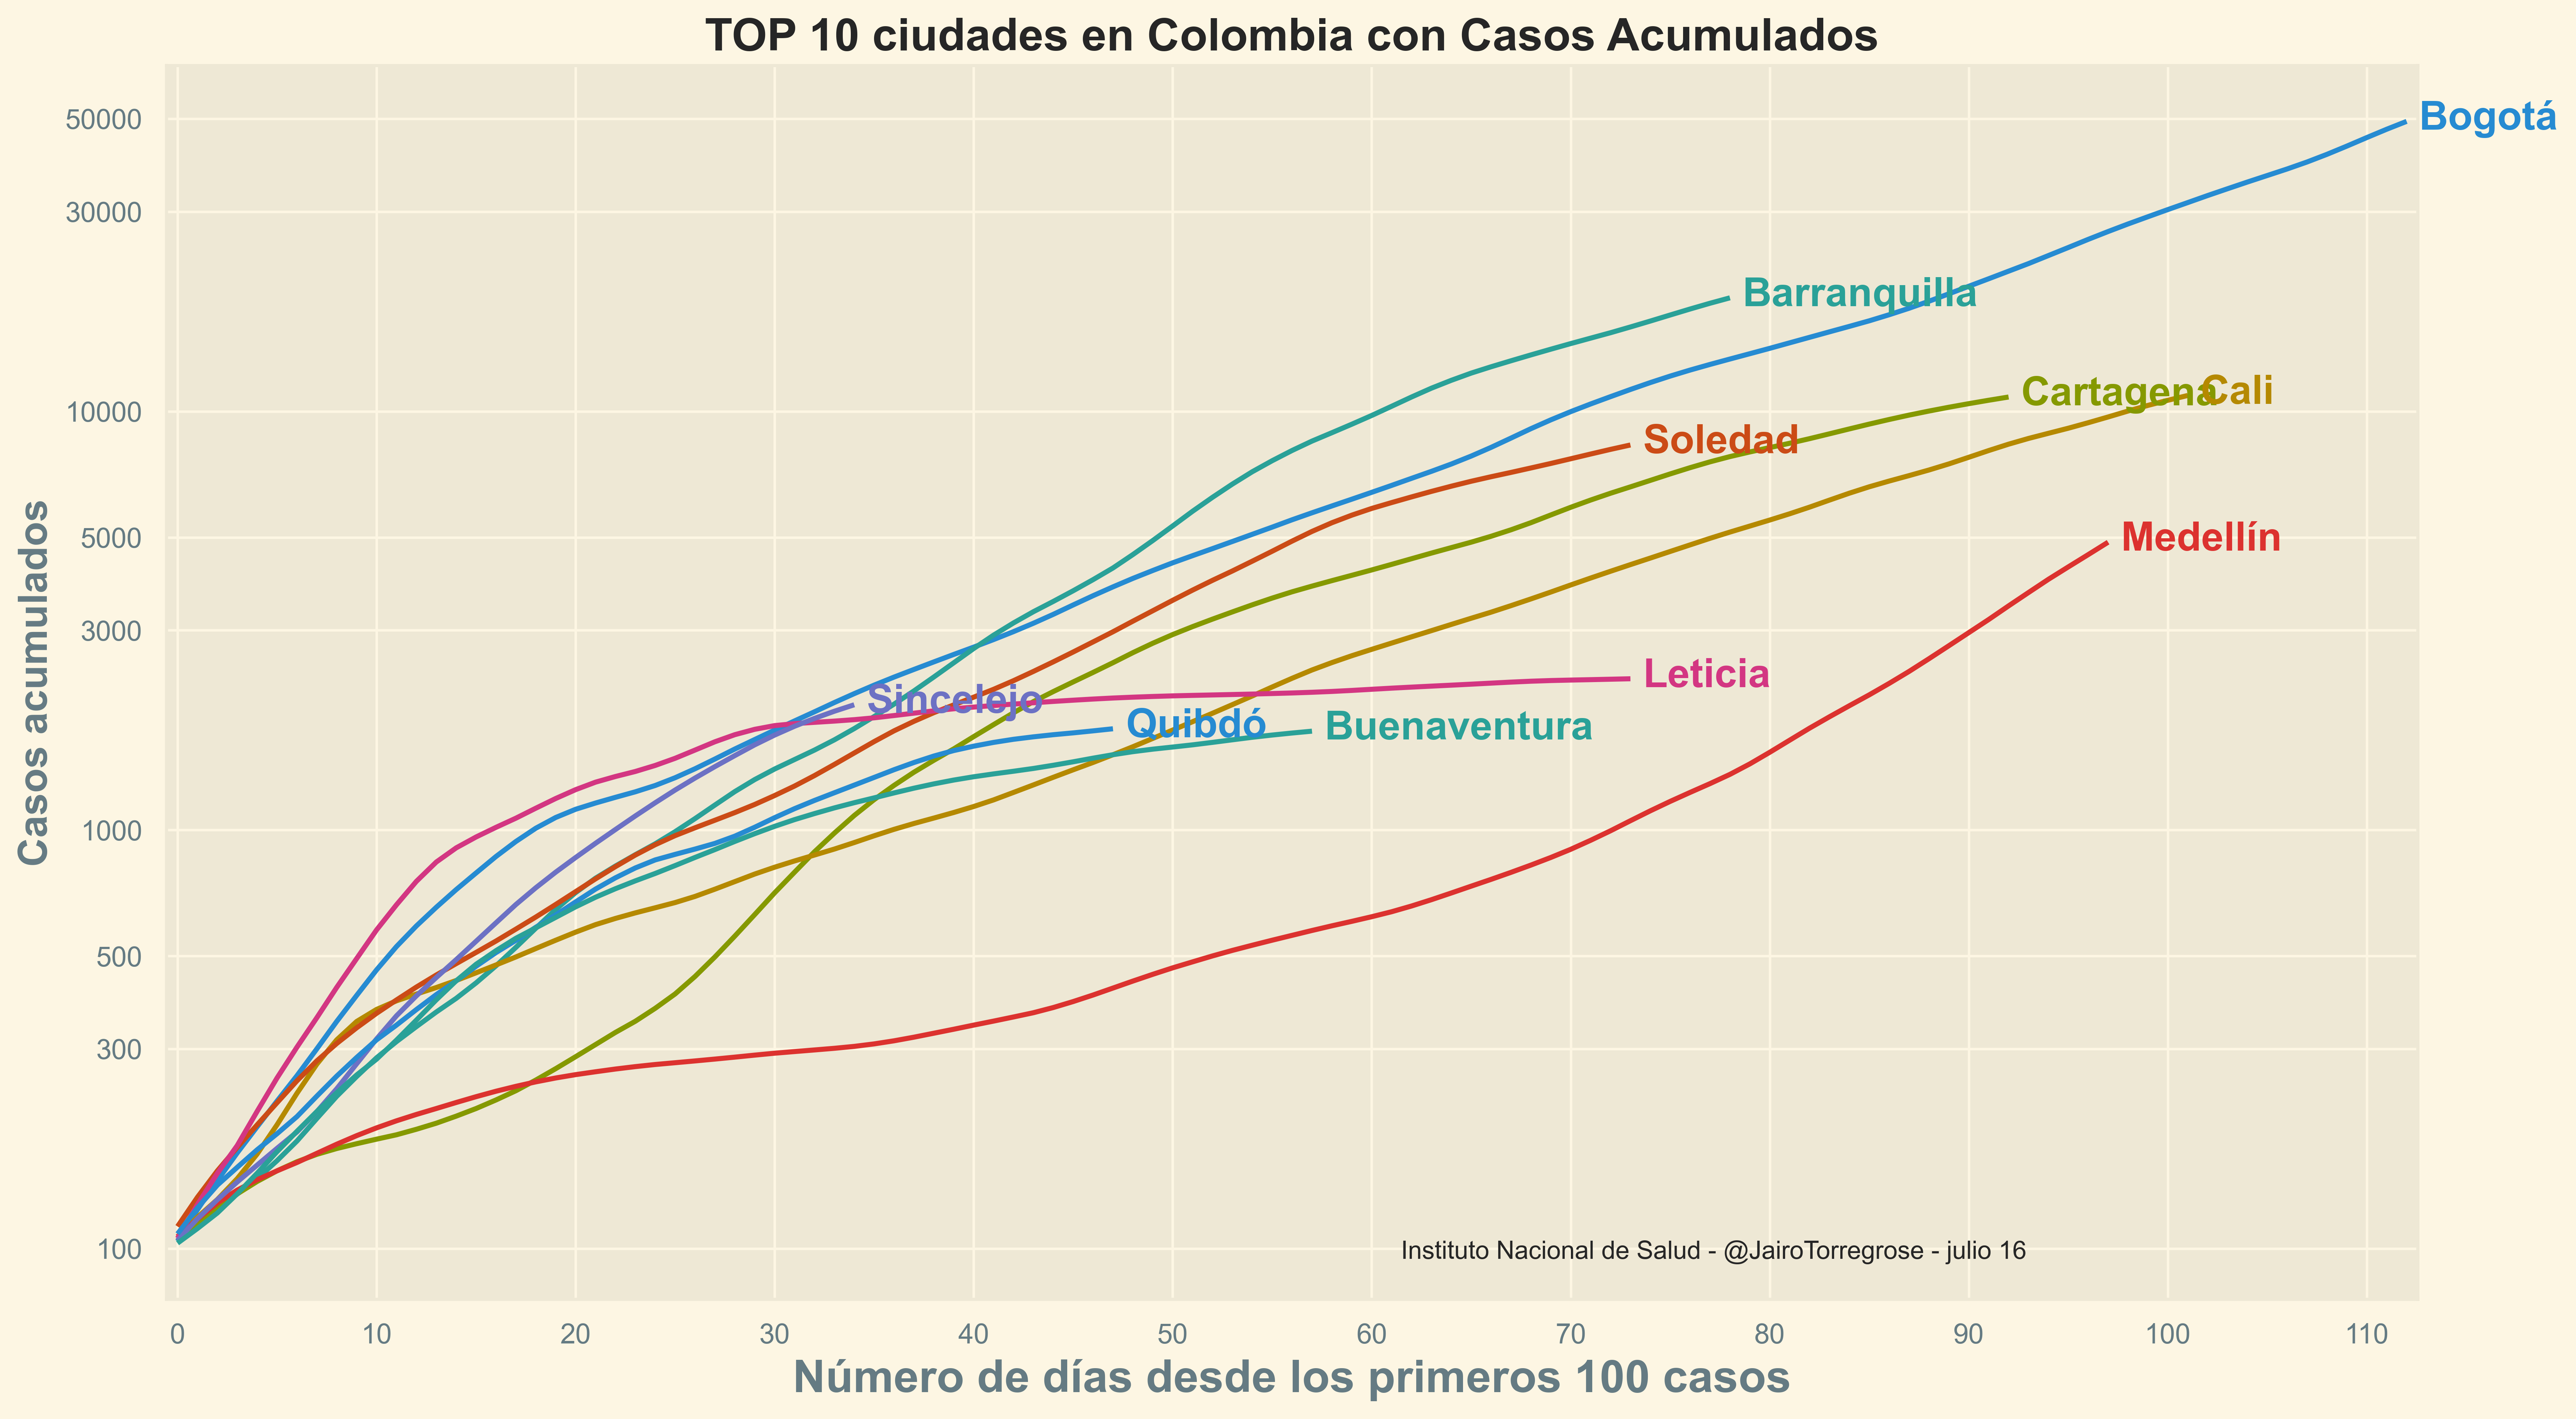

In [13]:
graficar(df_casos_acum, titulo_casos_acumulados,xlabel_casos_acumulados,ylabel_casos_acumulados ,texto_col)

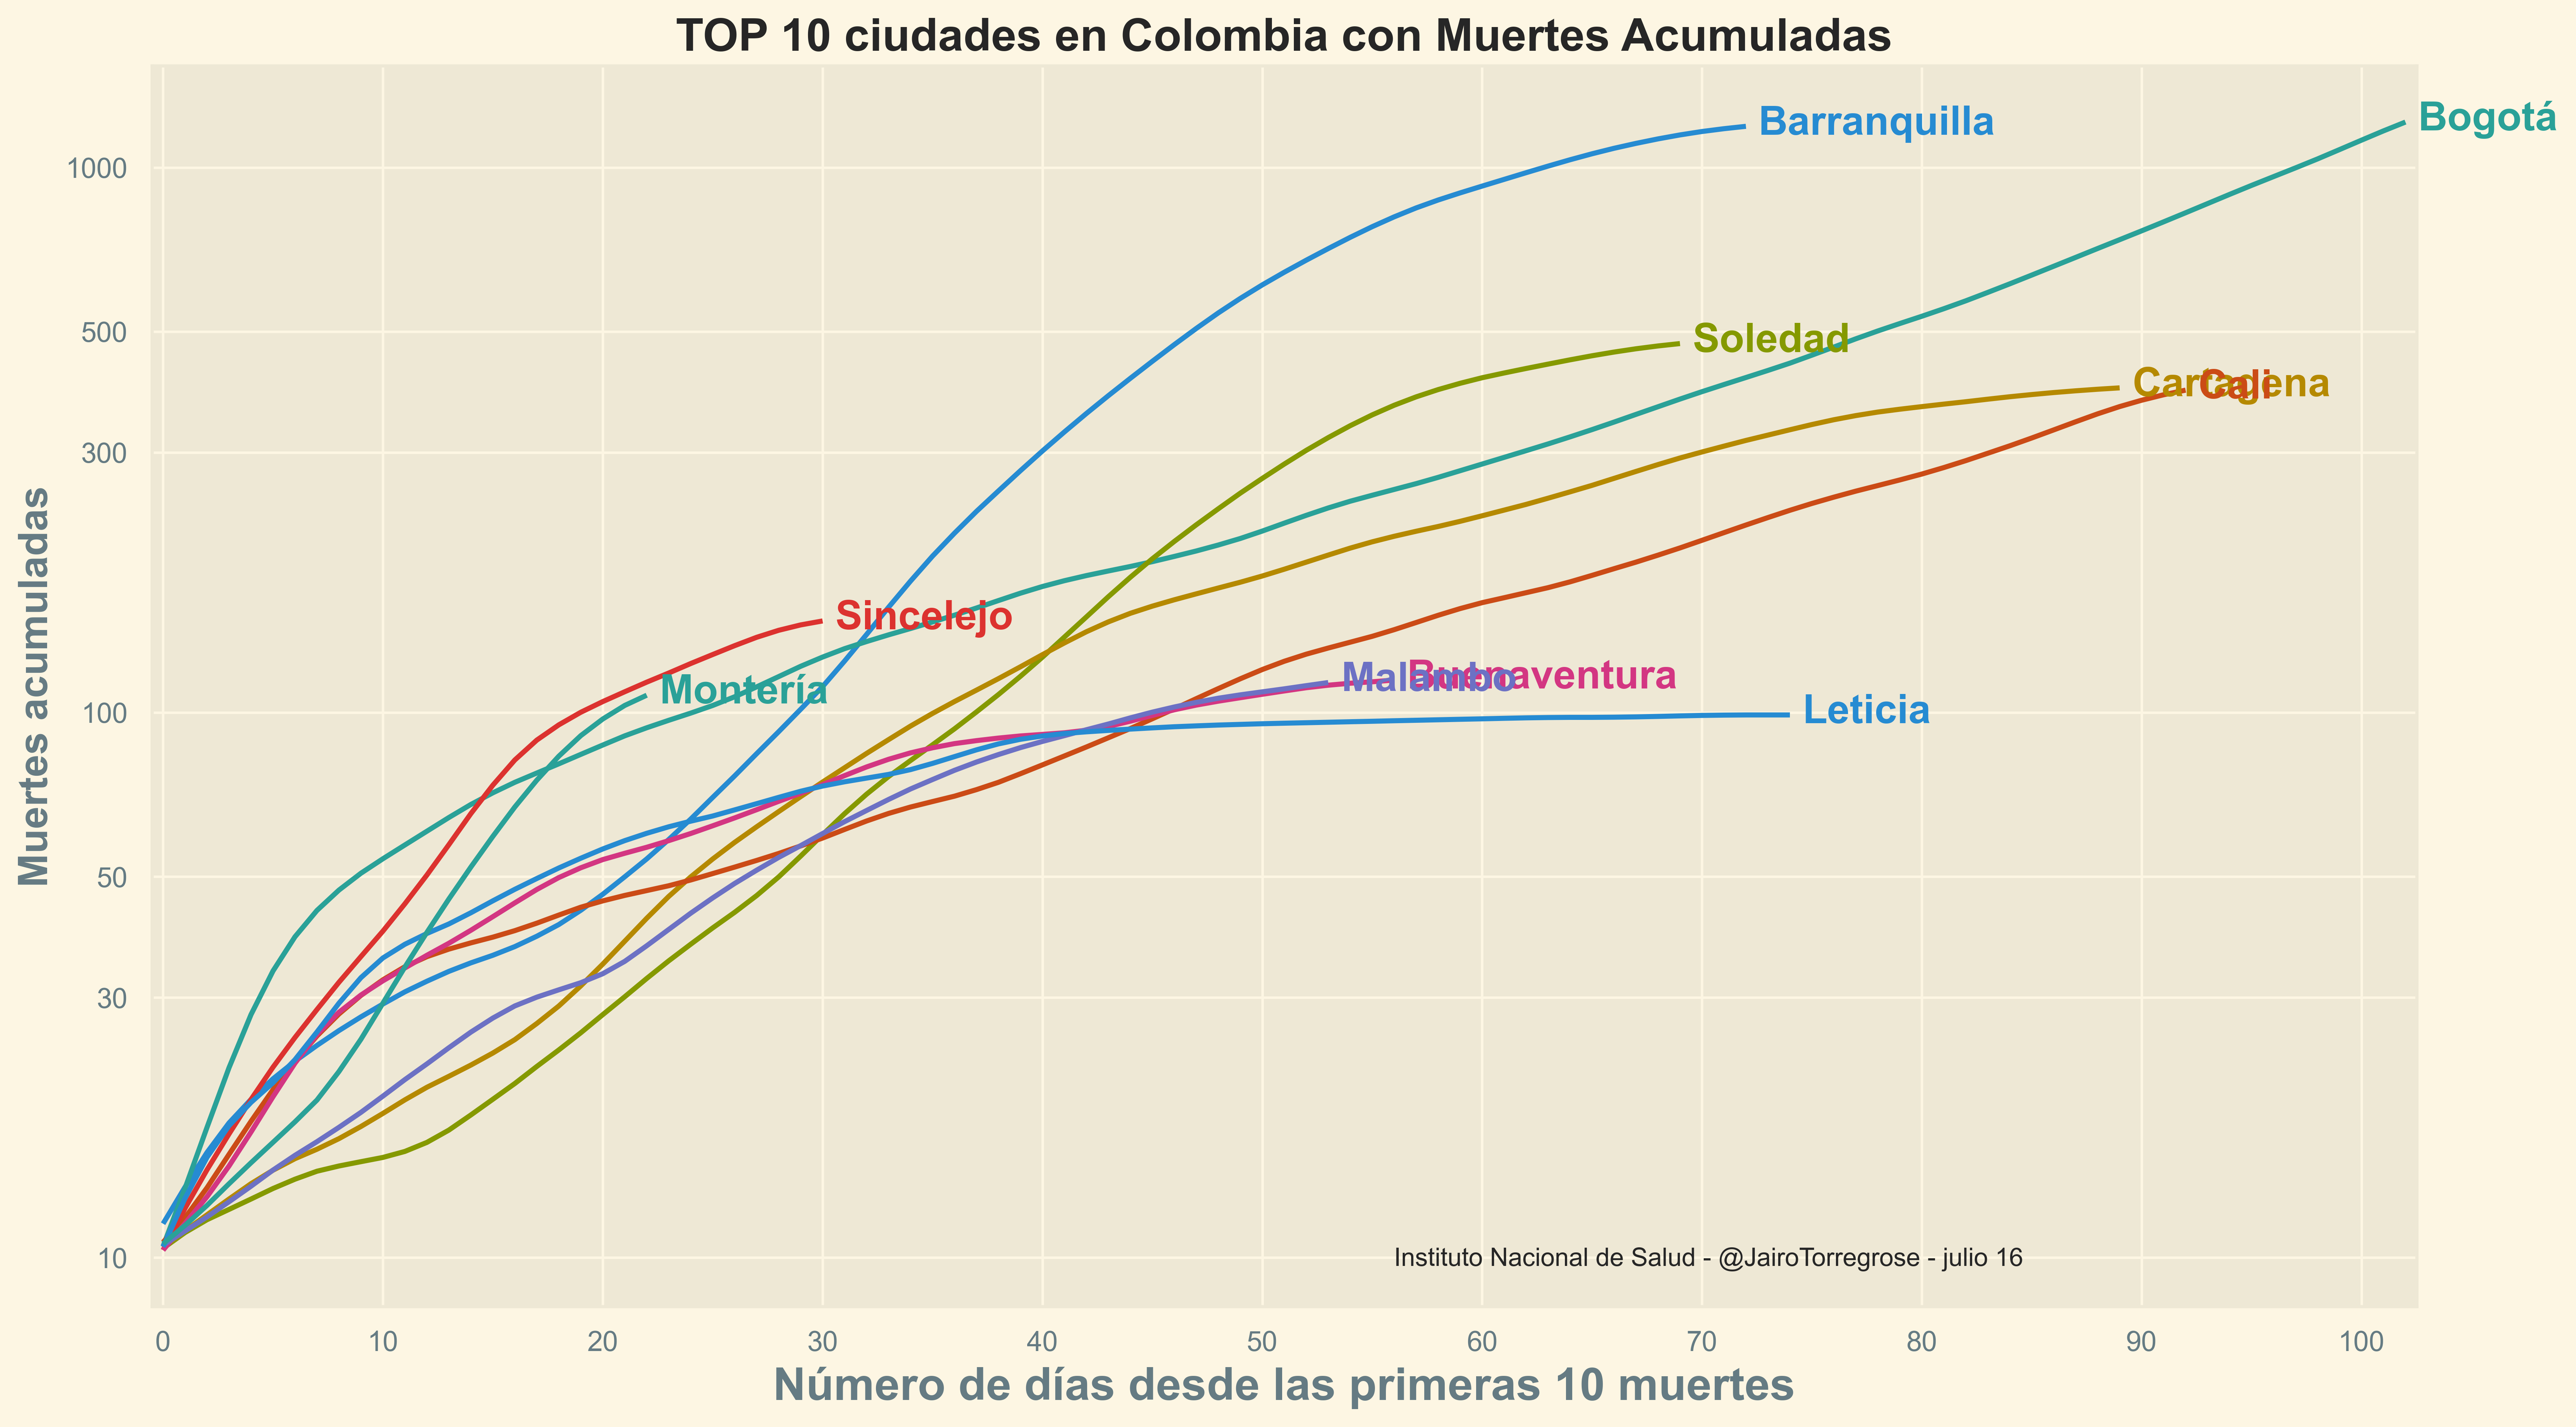

In [14]:
graficar(df_muertes_acum, titulo_muertes_acumuladas,xlabel_muertes_acumuladas,ylabel_muertes_acumuladas,texto_col)

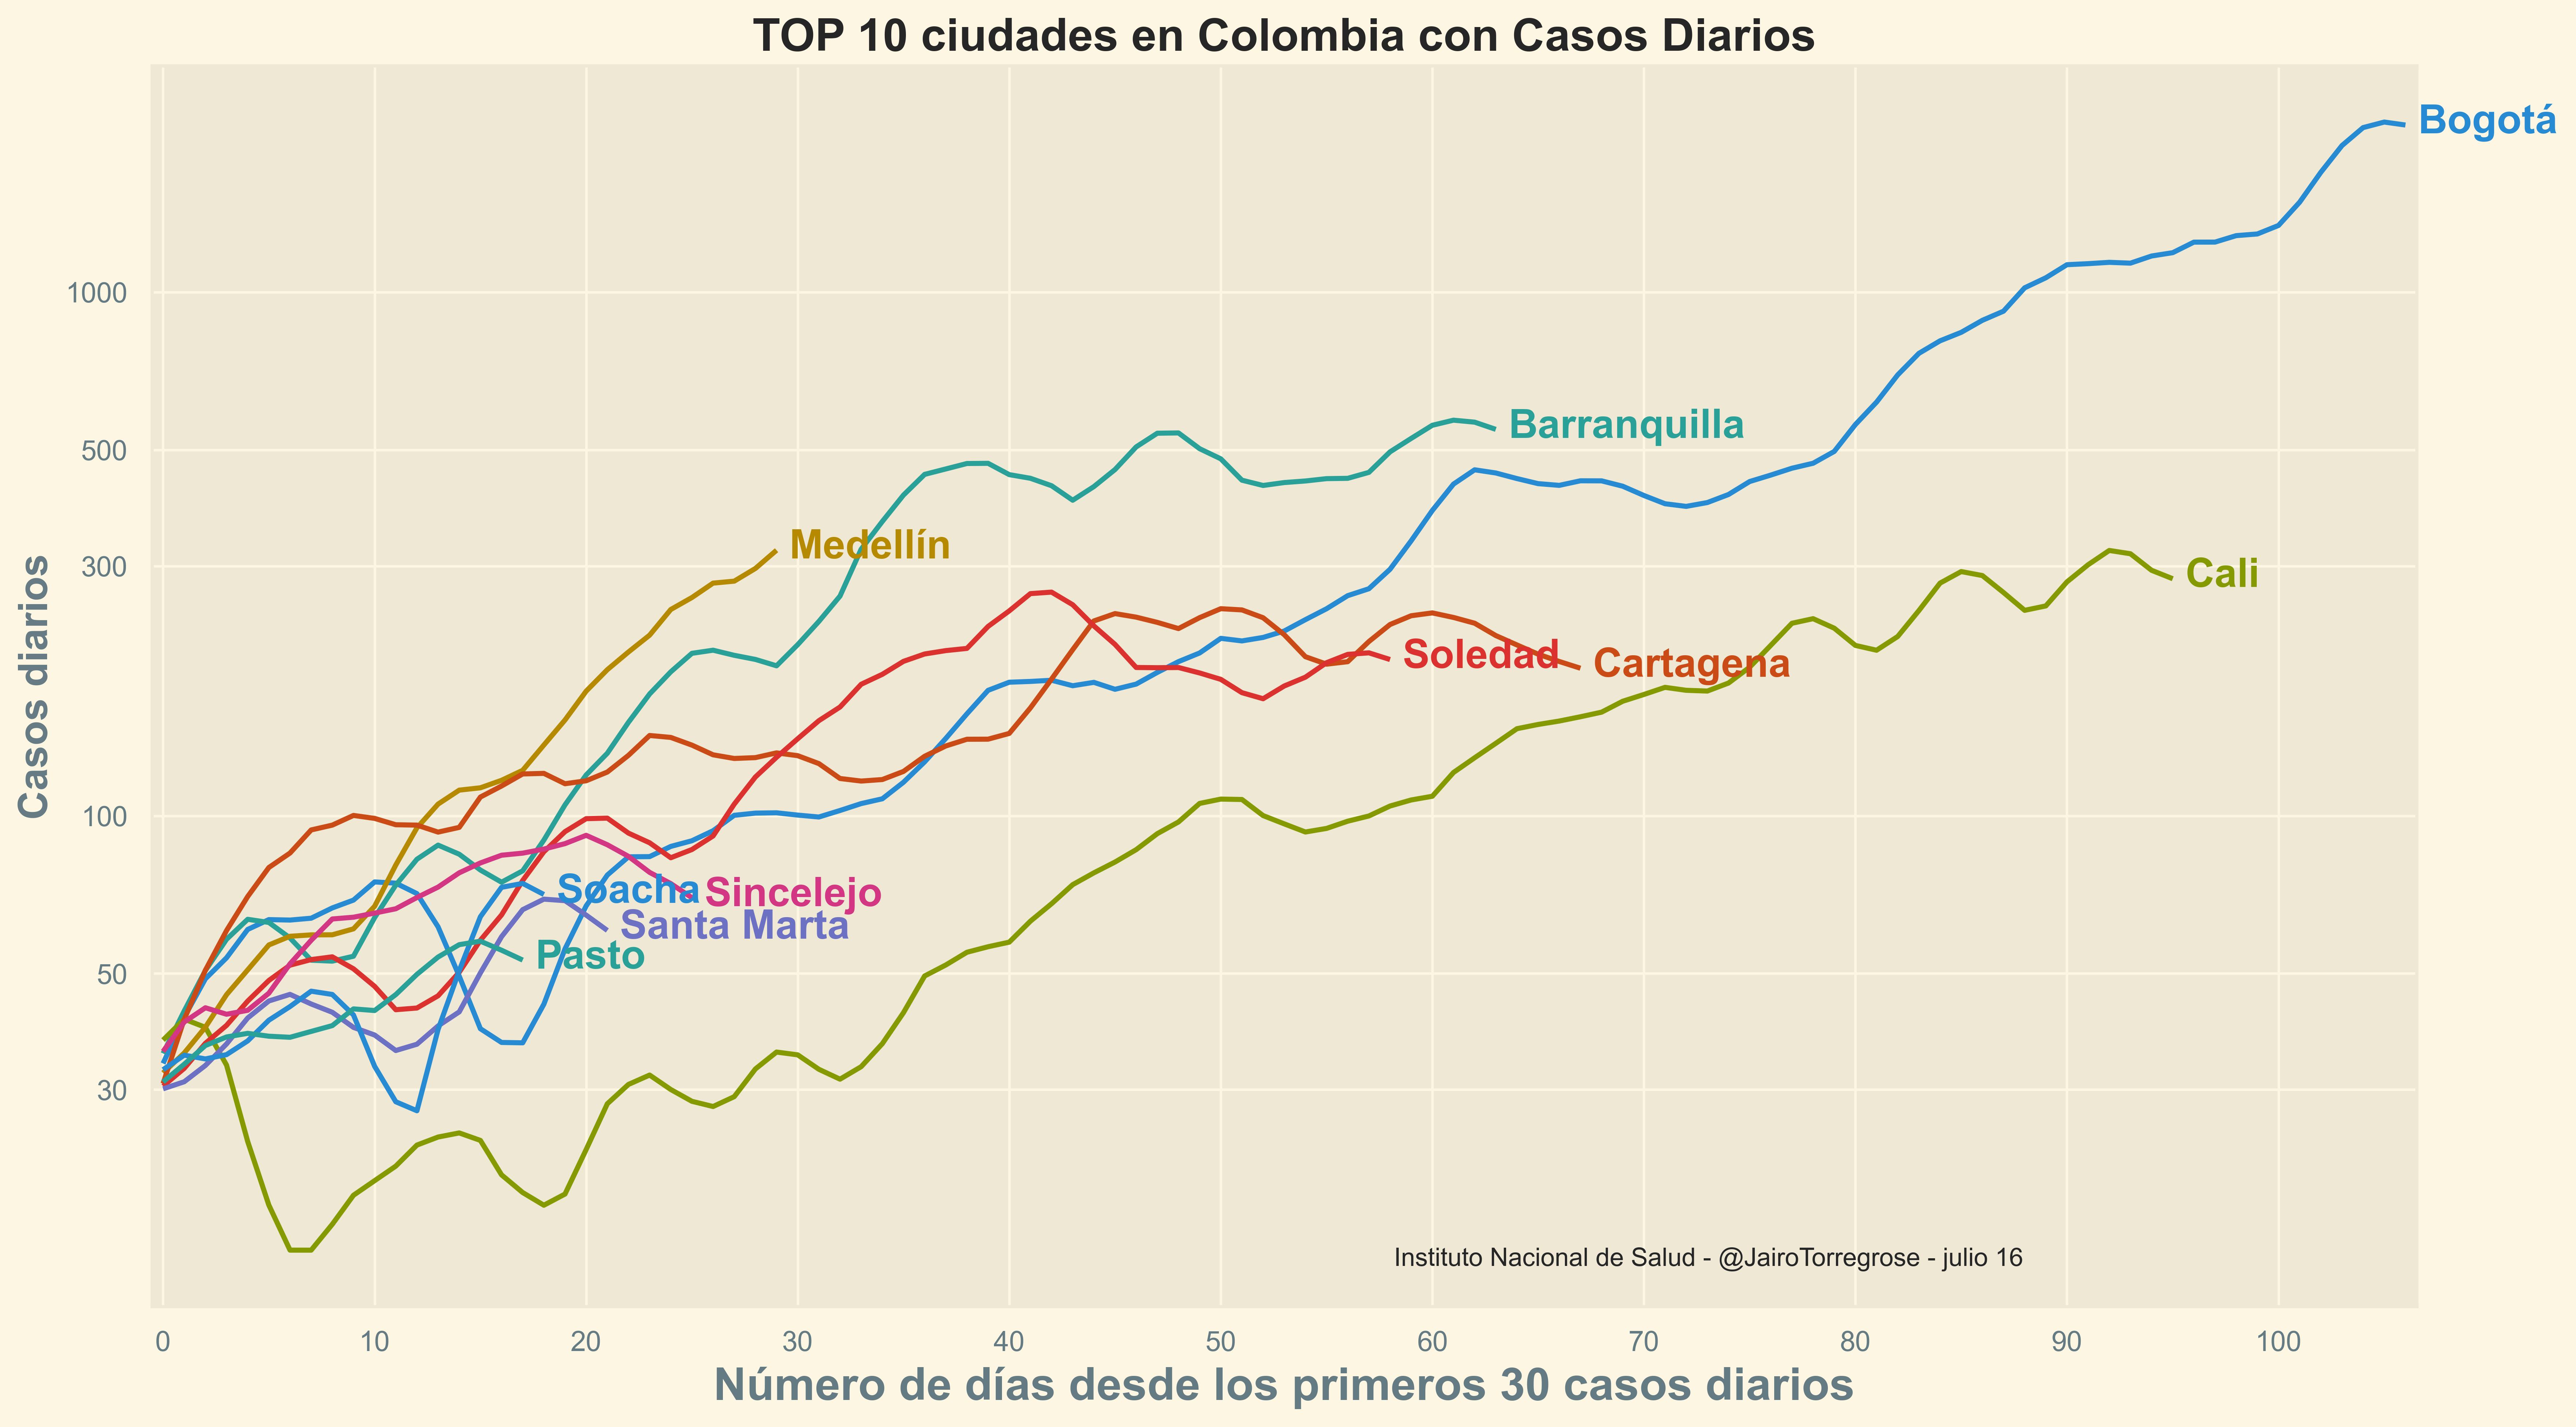

In [15]:
graficar(df_casos_diarios, titulo_casos_diarios, xlabel_casos_diarios, ylabel_casos_diarios,texto_col)

In [16]:
#graficar(df_muertes_diarias, titulo_muertes_diarias, xlabel_muertes_diarias, ylabel_muertes_diarias,texto_col)

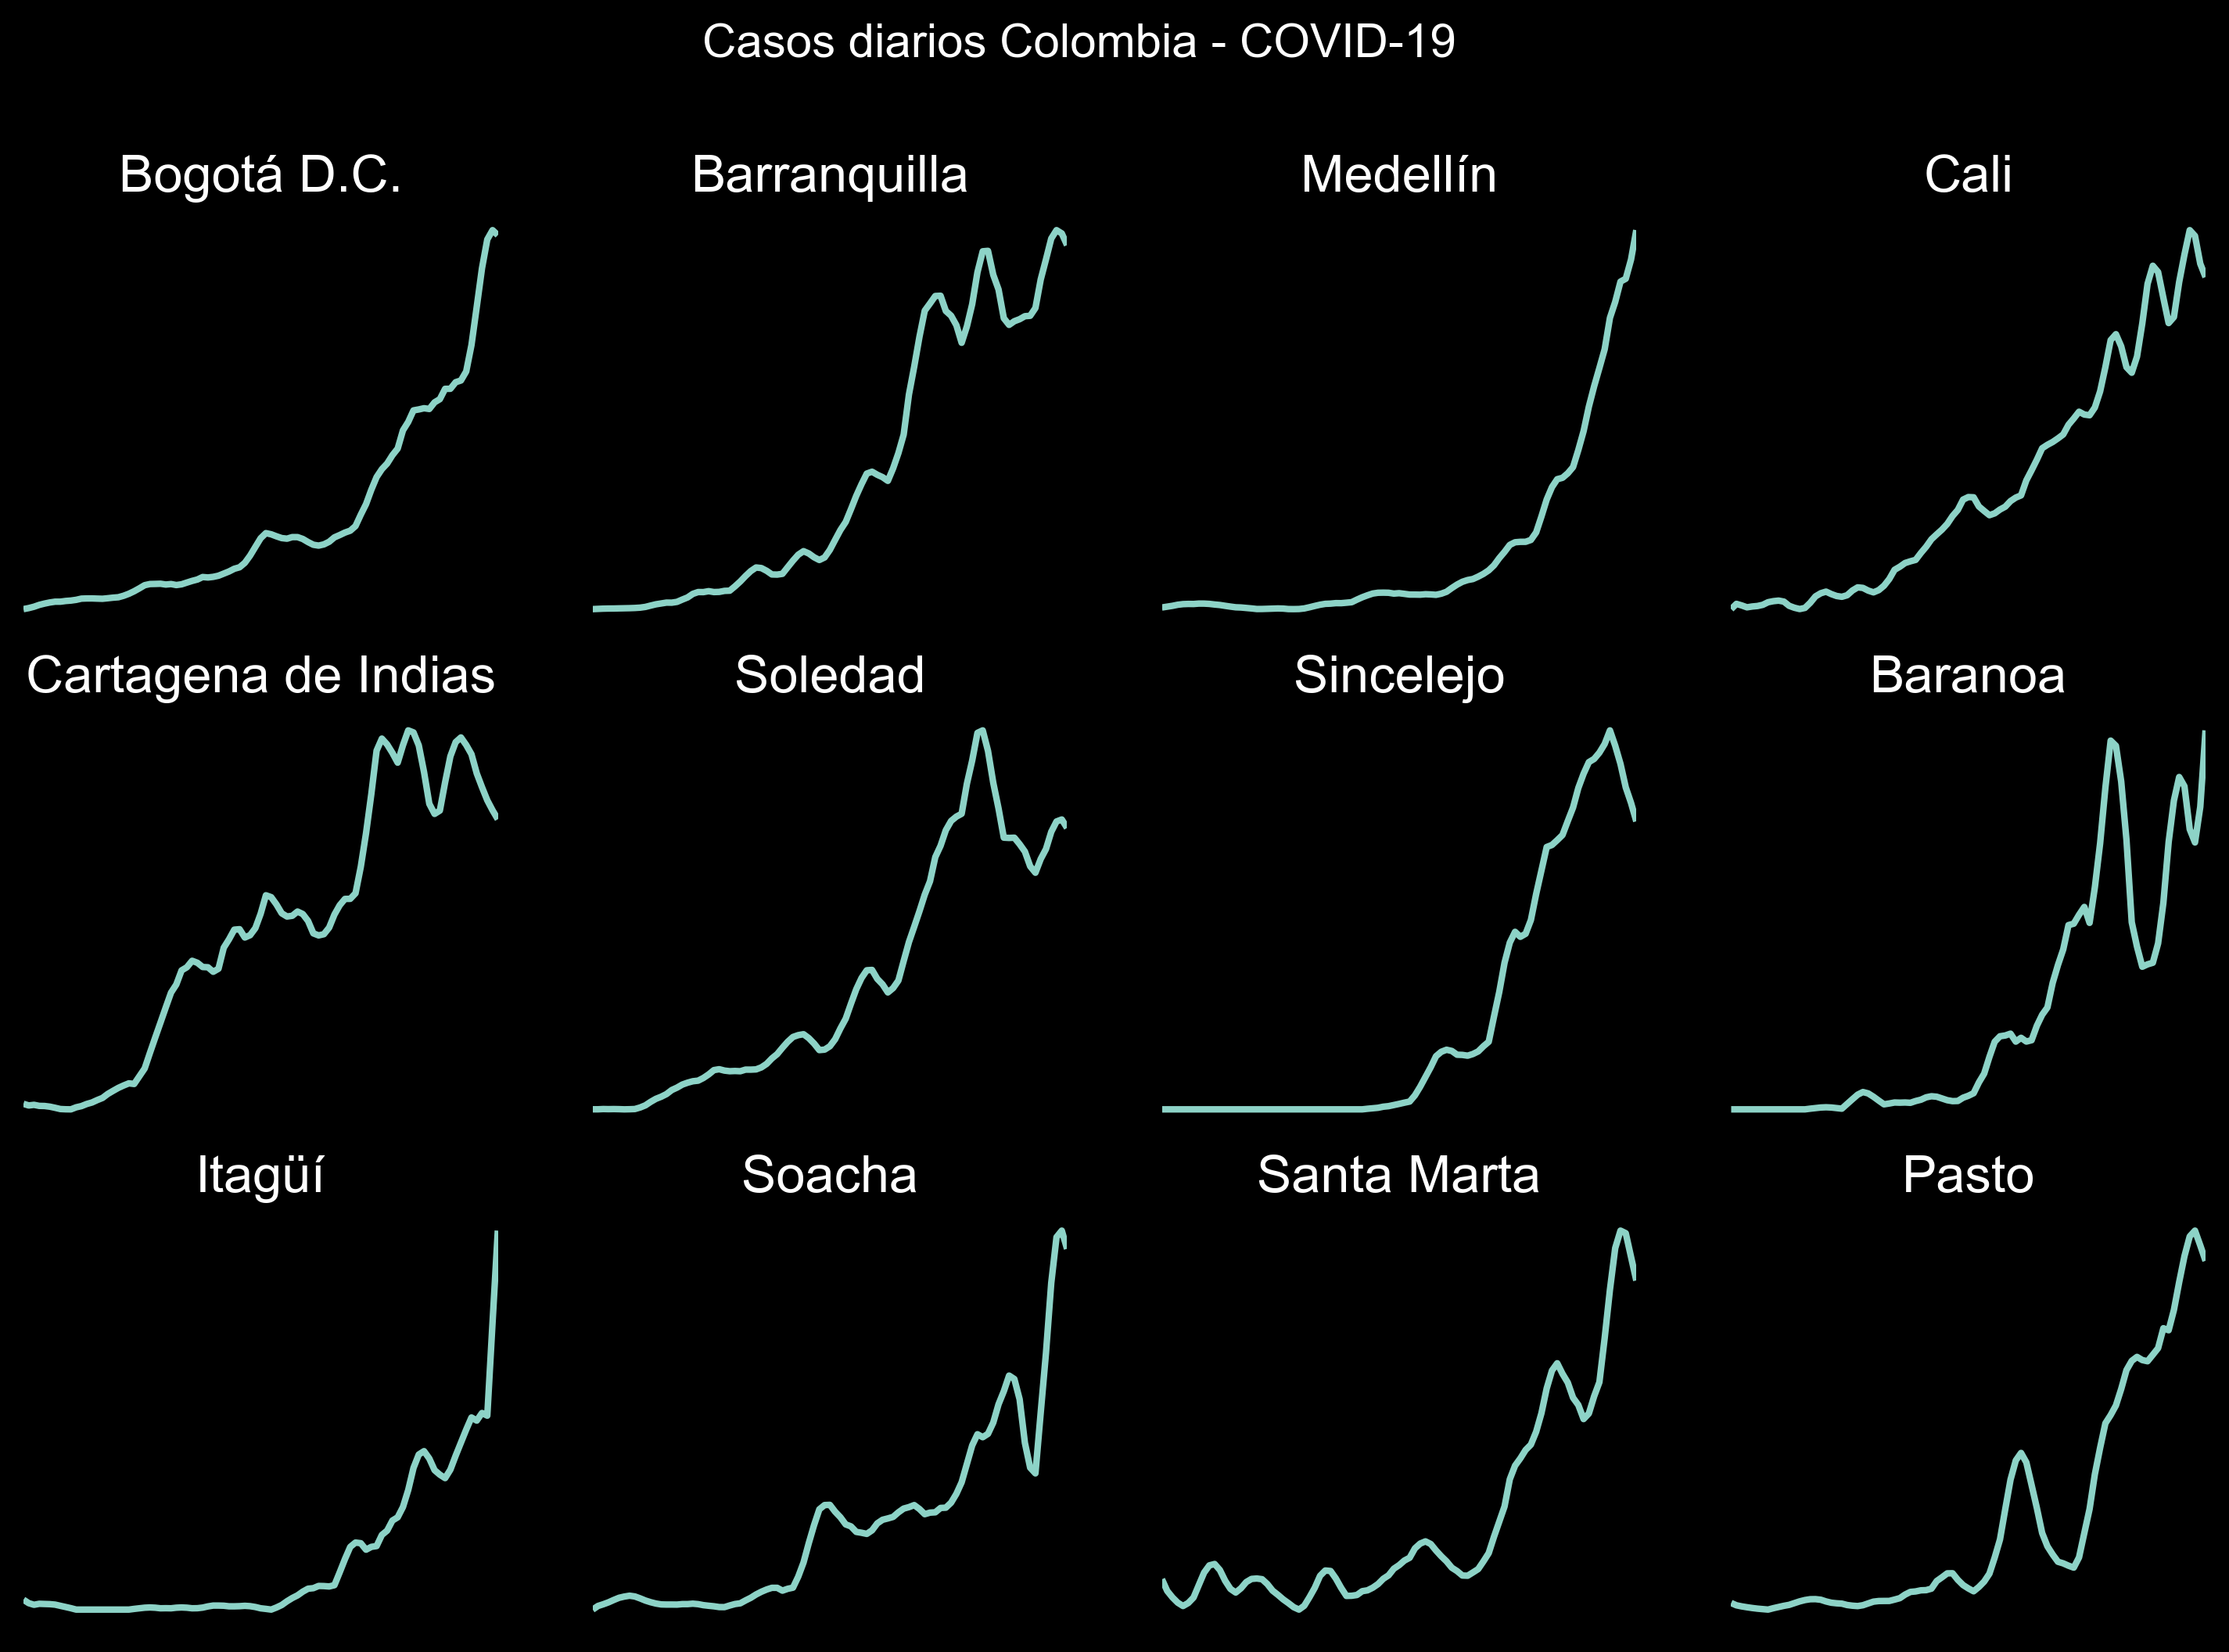

In [17]:
plt.style.use('dark_background')
diarios = casos.reindex( columns=casos.tail(3).mean().sort_values(ascending=False).index)
titulo = 'Casos diarios Colombia - COVID-19'
ciudades = diarios.columns[:12]
plt.figure(figsize=(12,8), dpi=300)
for i, ciudad in enumerate(ciudades):
    plt.subplot(3,4,i+1)
    fig = diarios.iloc[-91:,i].rolling(7, min_periods=1, win_type='gaussian').mean(std=2).plot()
    fig.set_title(ciudad)
    fig.axis('off')
plt.suptitle(titulo)
plt.savefig(f'{carpeta}{titulo}.png', bbox_inches='tight')
plt.show()

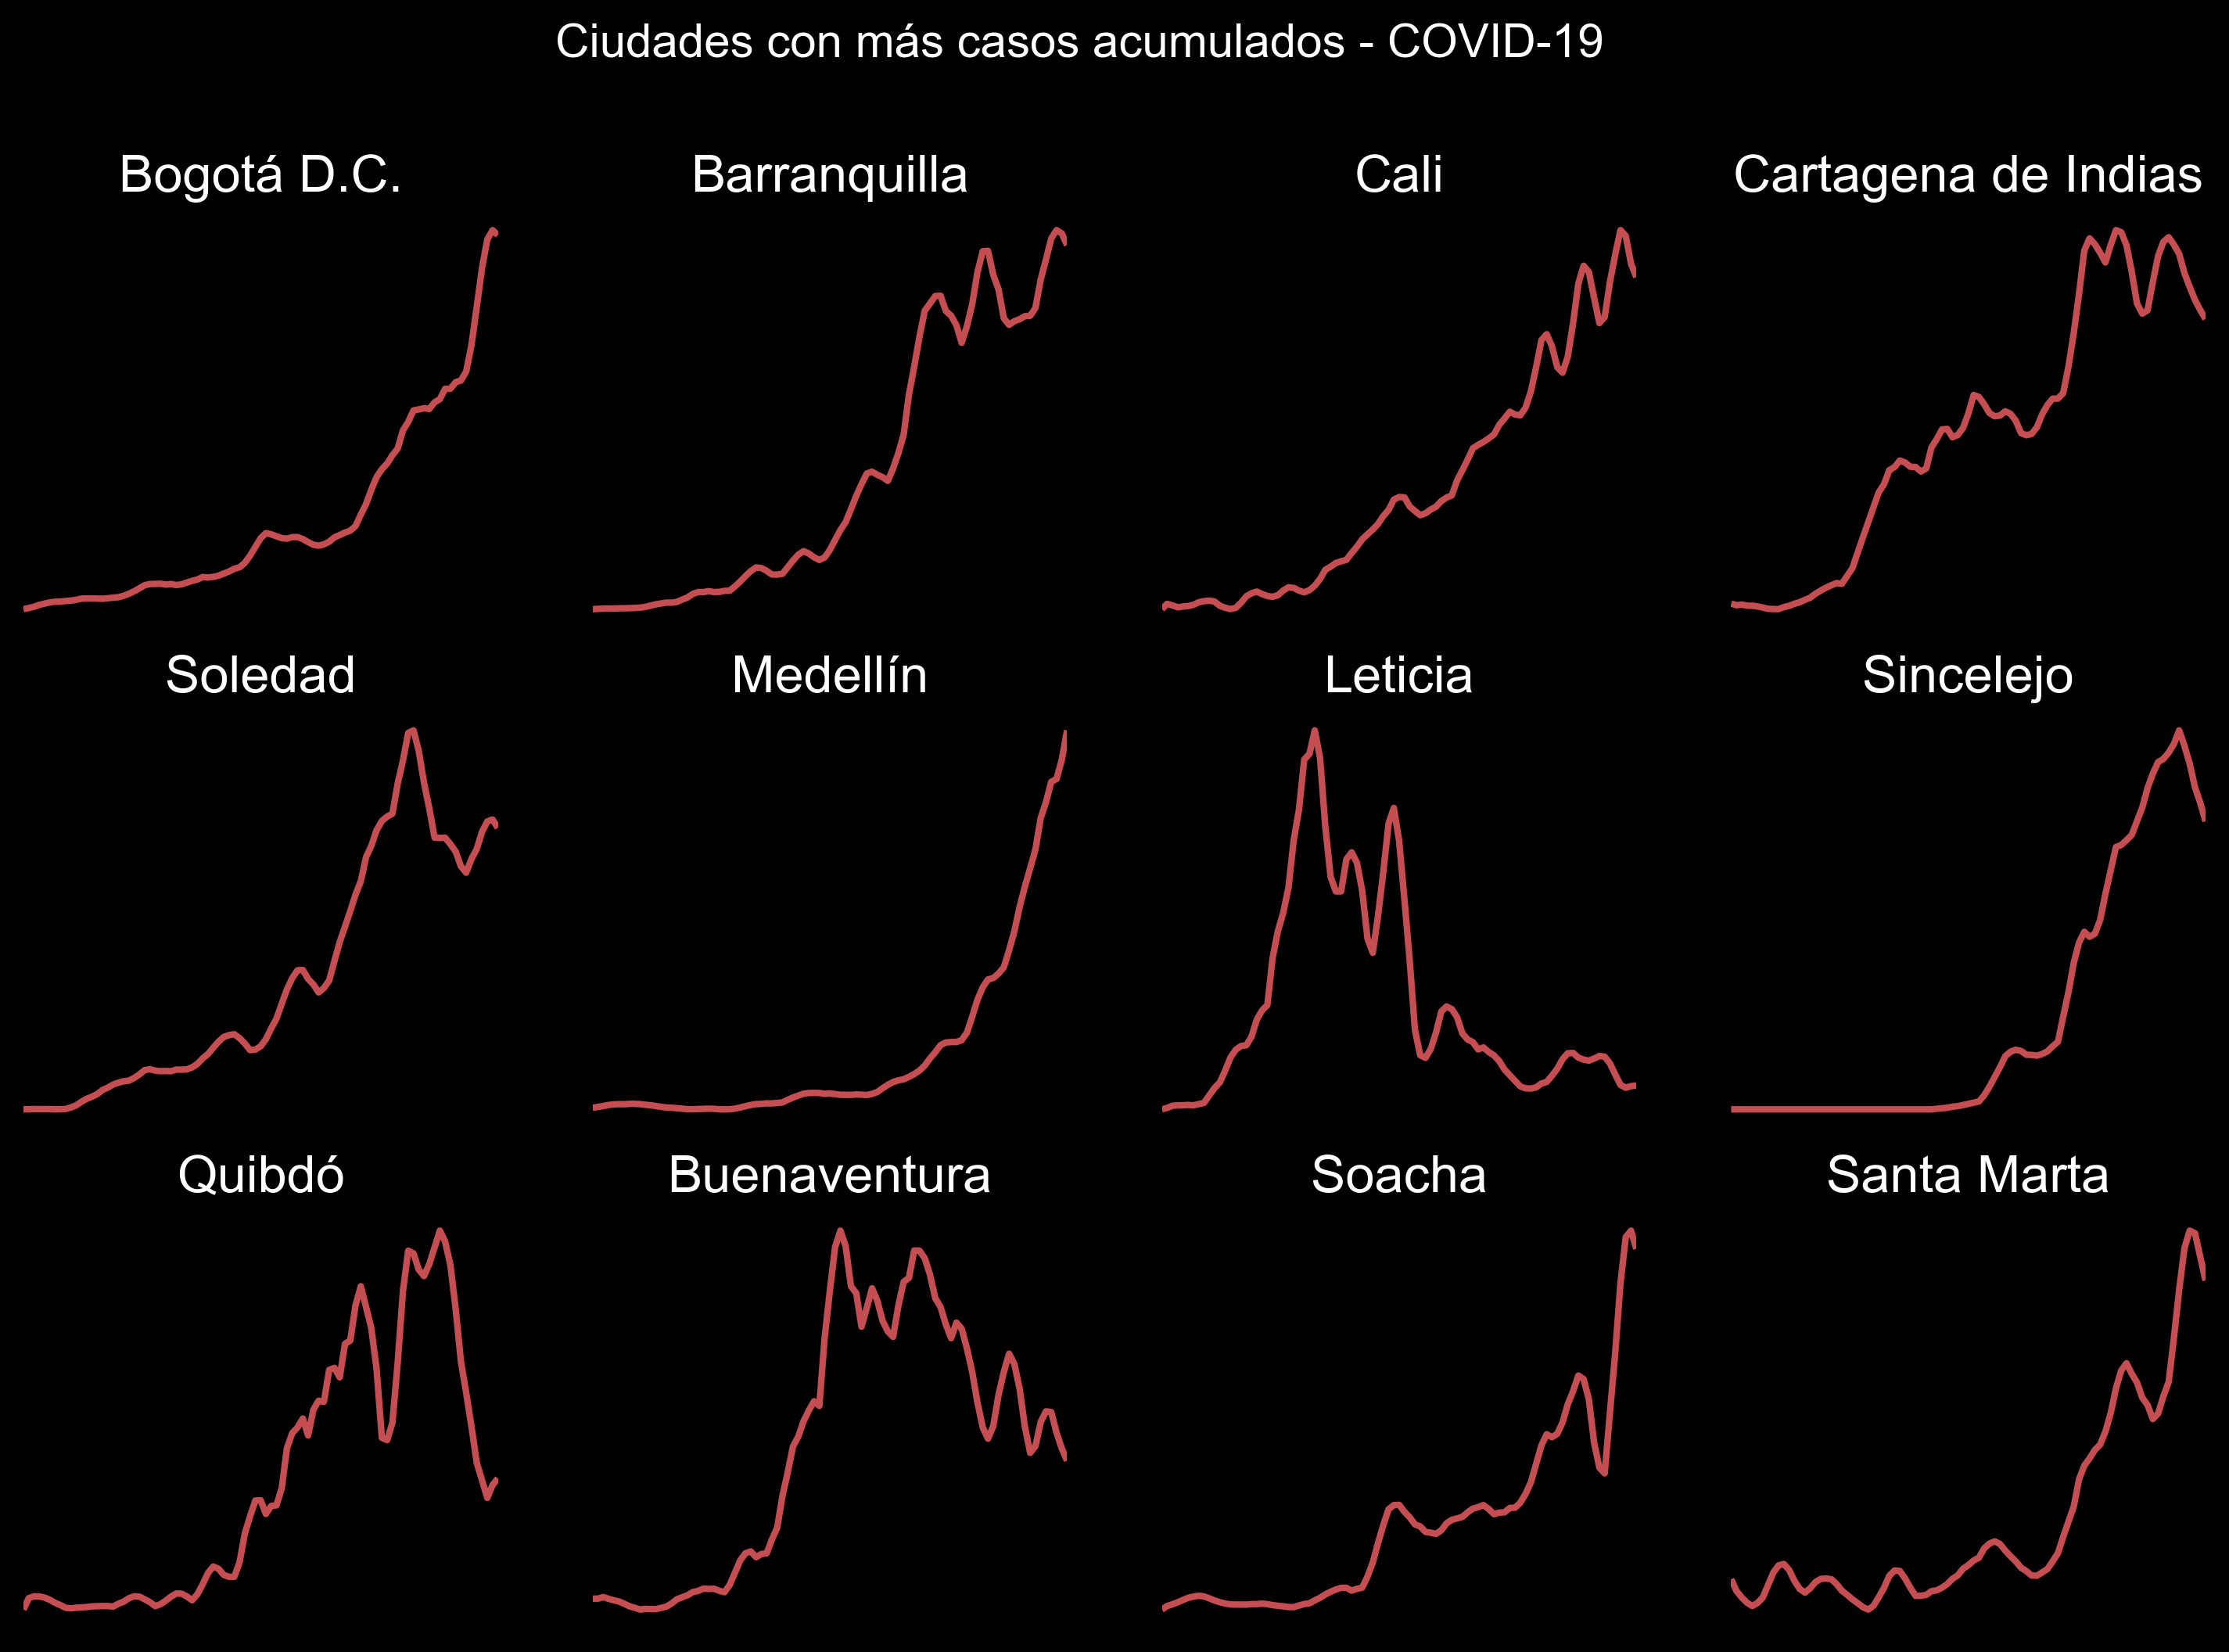

In [18]:
plt.style.use('dark_background')
diarios = casos.reindex( columns=casos.cumsum().tail(3).mean().sort_values(ascending=False).index)
acumulados = diarios.cumsum()
titulo = 'Ciudades con más casos acumulados - COVID-19'
ciudades = diarios.columns[:12]
plt.figure(figsize=(12,8), dpi=300)
for i, ciudad in enumerate(ciudades):
    plt.subplot(3,4,i+1)
    fig = diarios.iloc[-91:,i].rolling(7, min_periods=1, win_type='gaussian').mean(std=2).plot(color='r')
    fig.set_title(ciudad)
    fig.axis('off')
plt.suptitle(titulo)
plt.savefig(f'{carpeta}{titulo}.png', bbox_inches='tight')
plt.show()

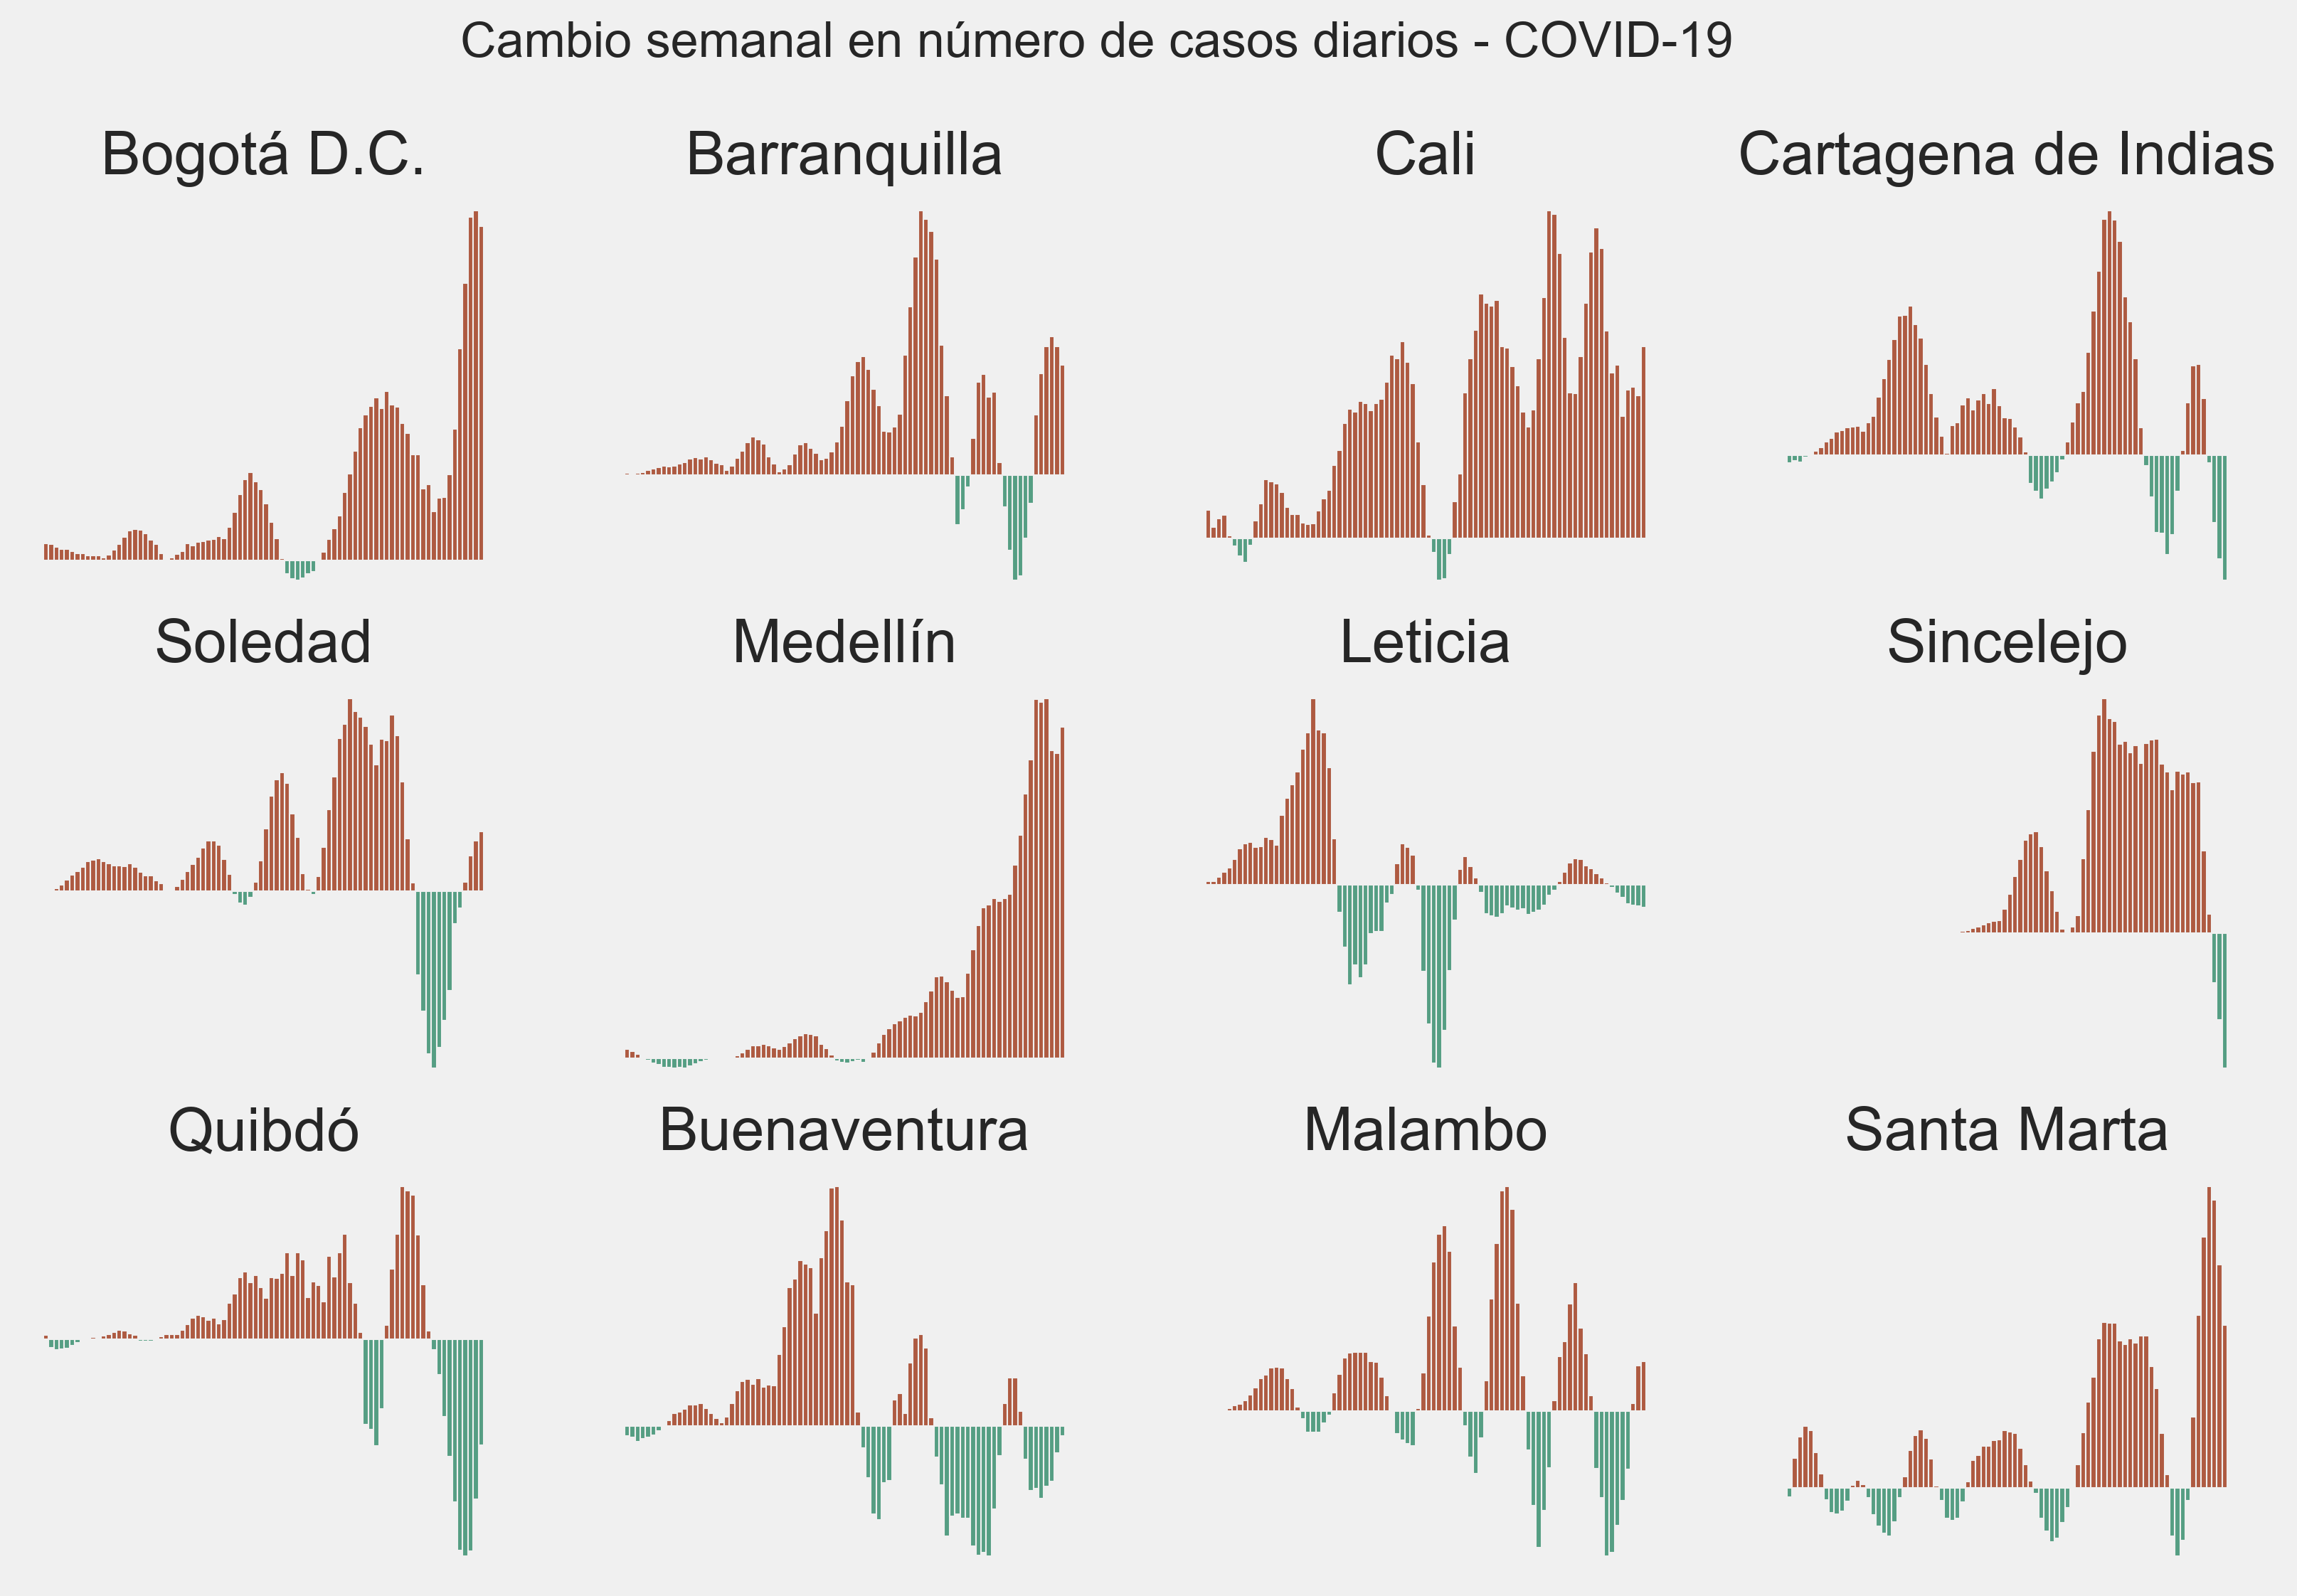

In [19]:
sns.set()
plt.style.use('fivethirtyeight')
diarios = casos.reindex( columns=casos.cumsum().tail(7).mean().sort_values(ascending=False).index)
acumulados = diarios.cumsum()
titulo = 'Cambio semanal en número de casos diarios - COVID-19'
ciudades = diarios.columns[:12]
plt.figure(figsize=(12,8), dpi=300)
for i, ciudad in enumerate(ciudades):
    fig = plt.subplot(3,4,i+1)
    df = diarios.iloc[-91:,i].rolling(7, min_periods=1, win_type='gaussian').mean(std=2)
    df = (df - df.shift(7)).dropna()
    #fig = sns.barplot(x = df.index, y = df , data=df)
    plt.bar(df[df>0].index, df[df>0].values, color='#ae5a41',width=1)
    plt.bar(df[df<=0].index, df[df<=0].values, color='#559e83',width=1)
    #fig = df.plot.bar()
    fig.set_title(ciudad)
    fig.axis('off')
plt.suptitle(titulo)
plt.savefig(f'{carpeta}{titulo}.png', bbox_inches='tight')
plt.show()

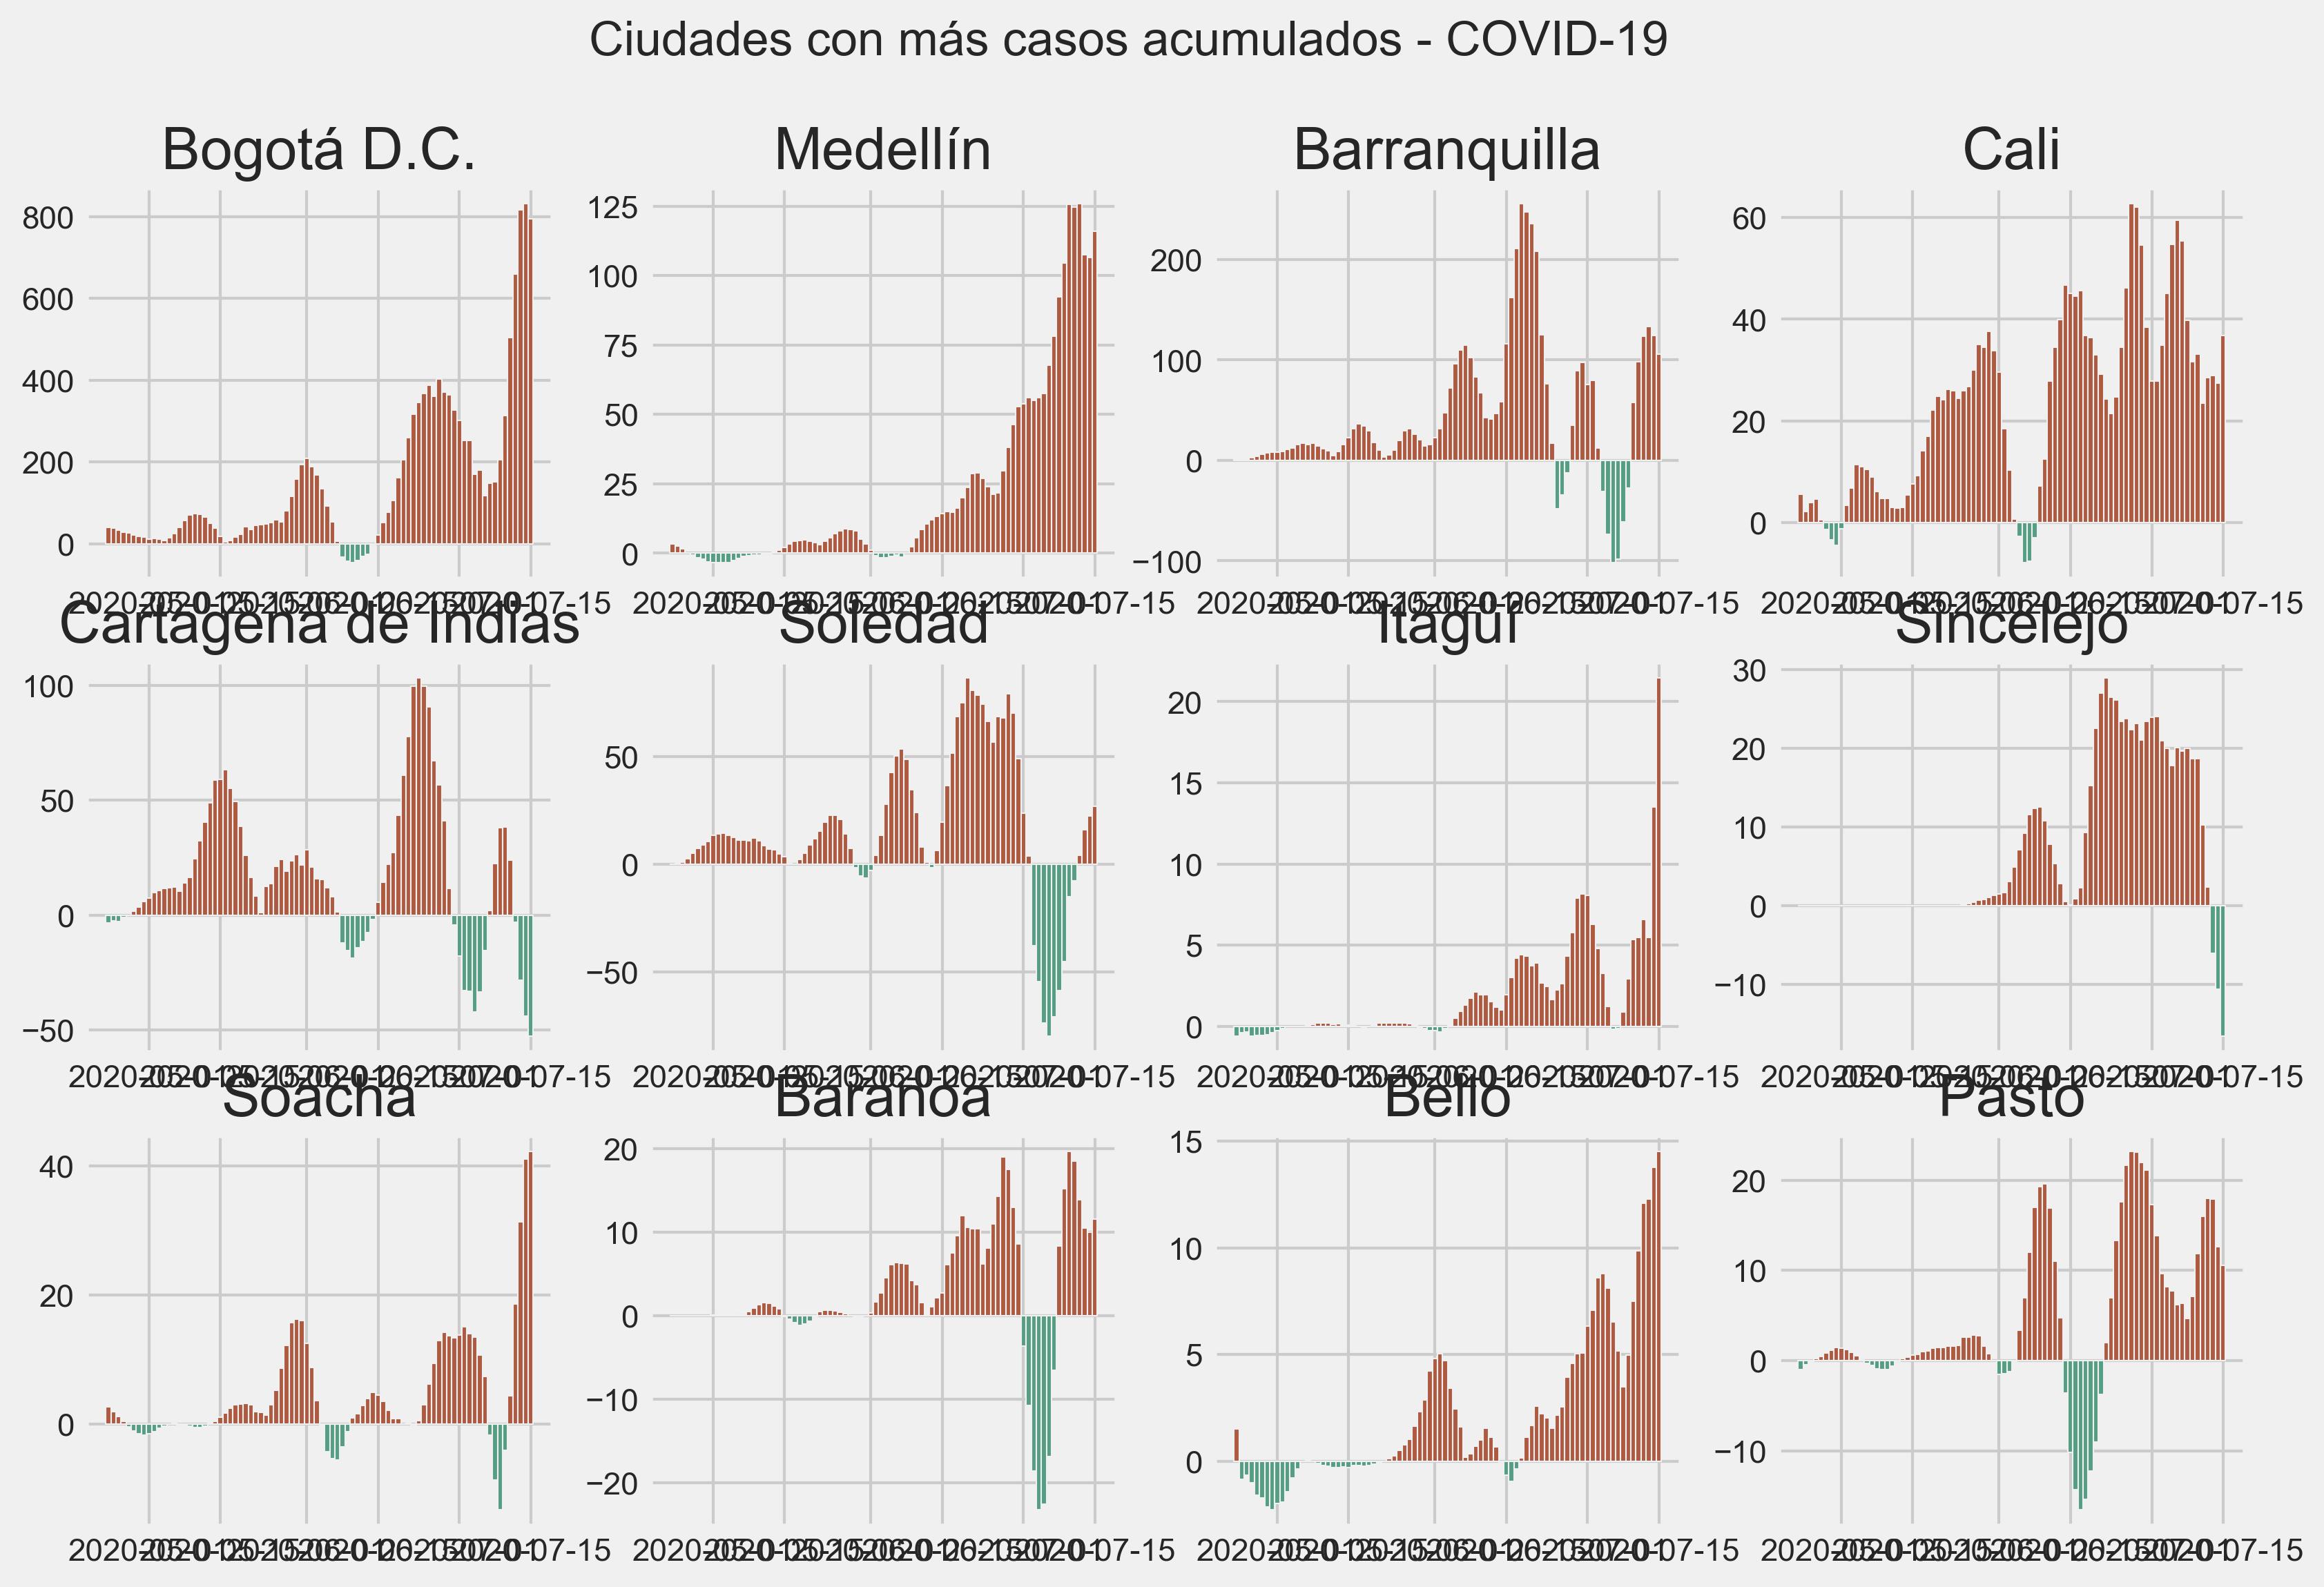

In [20]:
sns.set()
plt.style.use('fivethirtyeight')
diarios = casos.reindex( columns=casos.tail(2).mean().sort_values(ascending=False).index)
titulo = 'Ciudades con más casos acumulados - COVID-19'
ciudades = diarios.columns[:12]
plt.figure(figsize=(12,8), dpi=300)
for i, ciudad in enumerate(ciudades):
    fig = plt.subplot(3,4,i+1)
    df = diarios.iloc[-91:,i].rolling(7, min_periods=1, win_type='gaussian').mean(std=2)
    df = (df - df.shift(7)).dropna()
    #fig = sns.barplot(x = df.index, y = df , data=df)
    plt.bar(df[df>0].index, df[df>0].values, color='#ae5a41',width=1)
    plt.bar(df[df<=0].index, df[df<=0].values, color='#559e83',width=1)
    #fig = df.plot.bar()
    fig.set_title(ciudad)
    #fig.axis('off')
plt.suptitle(titulo)
#plt.savefig(f'{carpeta}{titulo}.png', bbox_inches='tight')
plt.show()